Might do this concurrently in PyTorch and Keras

In [341]:
%load_ext autoreload
%autoreload 2

import glob
import PIL
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

from scipy.optimize import fmin_l_bfgs_b
import scipy

from keras.models import Model
from keras import metrics
from keras import backend as K

from vgg16_avg import VGG16_Avg as vgg

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
path = '../data/train/'

In [3]:
fnames = glob.glob(path+'**/*.JPEG', recursive=True)
n = len(fnames); n

19439

In [65]:
fn = fnames[2090]; fn

'../data/train/n02102318/n02102318_10231.JPEG'

In [246]:
fn = '../data/train/n01558993/n01558993_9684.JPEG'

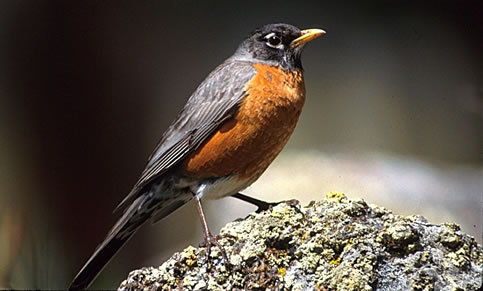

In [247]:
img=Image.open(fn); img

Need to subtract the VGG mean to make it work w/ VGG

In [248]:
rn_mean = np.array([123.68, 116.779, 103.939], dtype=np.float32)
preproc = lambda x: (x - rn_mean)[:, :, :, ::-1]
deproc = lambda x,s: np.clip(x.reshape(s)[:, :, :, ::-1] + rn_mean, 0, 255).astype(np.uint8)

Also reshape to add the "batch_size"

In [249]:
img_arr = preproc(np.expand_dims(np.array(img), 0))
shp = img_arr.shape

Here we get a pretrained net (VGG but with max pooling replaced with avg pooling to retain information)

In [291]:
rand_img = lambda shape: np.random.uniform(-2.5, 2.5, shape)/100
x = rand_img(shp)

In [251]:
class Evaluator(object):
    def __init__(self, f, shape): self.f, self.shp = f, shape
        
    def loss(self, x):
        loss_, self.grads_ = self.f([x.reshape(self.shp)])
        return loss_.astype(np.float64)
    
    def grads(self, x):
        return self.grads_.flatten().astype(np.float64)

In [283]:
def solve_image(eval_obj, img, niter):
    for _ in range(niter):
        img, min_val, info = fmin_l_bfgs_b(eval_obj.loss, img.flatten(),
                                        fprime=eval_obj.grads, maxfun=40)
        img = np.clip(img, -127, 127)
        print('Current loss value:', min_val)
    return img

First need to set up the image part - aka, put it through ~5 layers of VGG

In [253]:
model = vgg(include_top=False)

In [254]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (AveragePooling2 (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (AveragePooling2 (None, None, None, 128)   0         
__________

Choose the first conv on the fifth layer (can check out different ones, but this is the one they use)

In [255]:
layer = model.get_layer('block5_conv1').output

In [256]:
partial_model = Model(model.input, layer)

In [257]:
targ = partial_model.predict(img_arr)

In [258]:
targ.shape

(1, 18, 30, 512)

In [259]:
metrics.mse(layer, targ)

<tf.Tensor 'Mean_17:0' shape=(?, 18, 30) dtype=float32>

In [260]:
img_arr.shape

(1, 291, 483, 3)

In the most recent Keras, the MSE only takes the mean along the last axis (I guess because it's thinking about batches, or something). Here we want it over all the input pixels so I'm just writing it here

In [280]:
def mse(y_true, y_pred):
    return K.mean(K.square(y_pred - y_true))

In [281]:
loss = mse(layer, targ)
grads = K.gradients(loss, model.input)
fn = K.function([model.input], [loss]+grads)
evaluator = Evaluator(fn, shp)

In [293]:
y = solve_image(evaluator, x, 10)

Current loss value: 20.9240913391
Current loss value: 8.42450237274
Current loss value: 5.32804059982
Current loss value: 3.90967154503
Current loss value: 3.19171857834
Current loss value: 3.08028841019
Current loss value: 3.06967616081
Current loss value: 3.07380652428
Current loss value: 2.51966977119
Current loss value: 2.45979309082


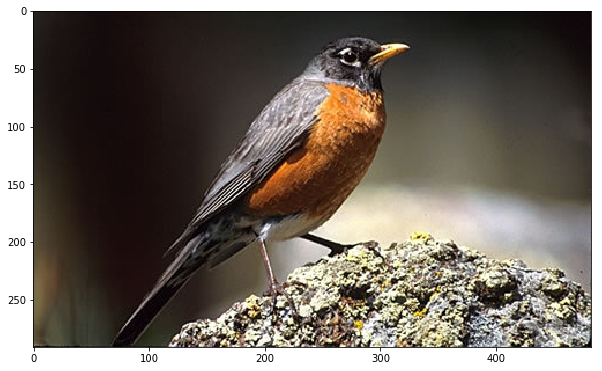

In [306]:
plt.figure(figsize=(10,10))
plt.imshow(deproc(img_arr.copy(), shp)[0])

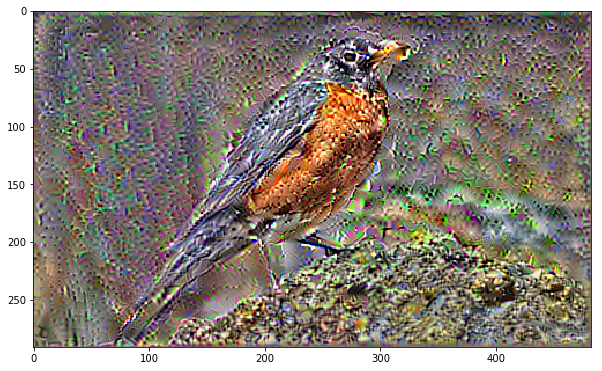

In [307]:
plt.figure(figsize=(10,10))
plt.imshow(deproc(y.copy(), shp)[0])

OK! Now for the style part. Same thing, but with a given style. Gonna use this picasso image that I got off Google

In [326]:
picasso_fp = '../data/picasso.jpg'

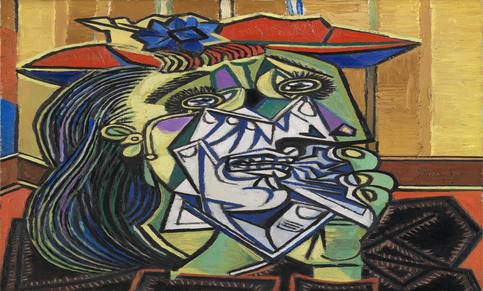

In [331]:
style_img = Image.open(picasso_fp) ; style_img

In [333]:
style_arr = preproc(np.expand_dims(style_img,0)[:,:,:,:3])
style_shp = style_arr.shape

In [334]:
model = VGG16_Avg(include_top=False, input_shape=shp[1:])
outputs = {l.name: l.output for l in model.layers}

We're gonna use several layers here. We could have also done this for the style bits too.

In [335]:
layers = [outputs['block{}_conv1'.format(o)] for o in range(1,3)]

In [336]:
layers_model = Model(model.input, layers)
targs = [K.variable(o) for o in layers_model.predict(style_arr)]

We use the gramian matrix. No one really knows why it works, other than because it works out how much the features correlate and therefore throws away all location data whilst keeping 'texture' data

In [337]:
def gram_matrix(x):
    # We want each row to be a channel, and the columns to be flattened x,y locations
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    # The dot product of this with its transpose shows the correlation 
    # between each pair of channels
    return K.dot(features, K.transpose(features)) / x.get_shape().num_elements()

In [338]:
def style_loss(x, targ): return mse(gram_matrix(x), gram_matrix(targ))

In [339]:
loss = sum(style_loss(l1[0], l2[0]) for l1,l2 in zip(layers, targs))
grads = K.gradients(loss, model.input)
style_fn = K.function([model.input], [loss]+grads)
evaluator = Evaluator(style_fn, shp)

In [343]:
rand_img = lambda shape: np.random.uniform(-2.5, 2.5, shape)/1
x = rand_img(shp)

In [344]:
y = solve_image(evaluator, x, 10)

Current loss value: 282.913482666
Current loss value: 33.8392562866
Current loss value: 9.01172447205
Current loss value: 4.52065467834
Current loss value: 2.64742183685
Current loss value: 1.68302261829
Current loss value: 1.2161719799
Current loss value: 1.04579091072
Current loss value: 1.03820323944
Current loss value: 1.04473853111


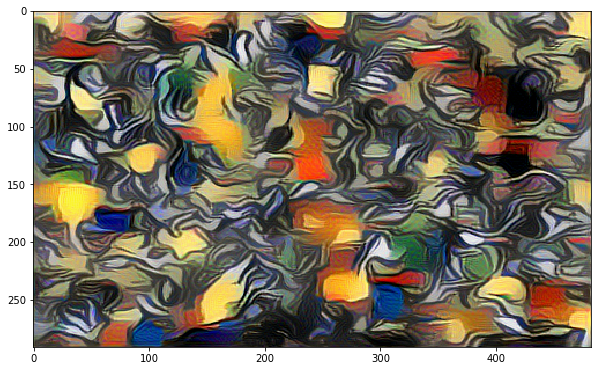

In [345]:
plt.figure(figsize=(10,10))
plt.imshow(deproc(y.copy(), shp)[0])

Putting it together!

In [375]:
model = vgg(include_top=False, input_shape=shp[1:])
outputs = {l.name:l.output for l in model.layers}

In [389]:
content_layer = model.get_layer('block4_conv2').output
style_layers = [outputs['block{}_conv1'.format(o)] for o in range(1,6)]
content_model = Model(model.input, content_layer)
style_model = Model(model.input, style_layers)

In [390]:
style_targs = [K.variable(o) for o in style_model.predict(style_arr)]
content_targ = K.variable(content_model.predict(img_arr))

Content loss we're dividing by 10 to let the style have more of a look in.

TO WRITE: the weights, number of style layers, content loss weighting are important. Figure out how important!

In [391]:
style_wgts = [0.05,0.2,0.2,0.25,0.3]

In [392]:
loss = sum(style_loss(l1[0], l2[0])*w
           for l1,l2, w in zip(style_layers, style_targs, style_wgts))
loss += mse(content_layer, content_targ)/15
grads = K.gradients(loss, model.input)
transfer_fn = K.function([model.input], [loss]+grads)

In [393]:
evaluator = Evaluator(transfer_fn, shp)

In [394]:
x = rand_img(shp)

In [395]:
y = solve_image(evaluator, x, 10)

Current loss value: 565.049743652
Current loss value: 320.408538818
Current loss value: 254.680877686
Current loss value: 219.899810791
Current loss value: 205.394744873
Current loss value: 196.626358032
Current loss value: 191.031387329
Current loss value: 186.75378418
Current loss value: 183.020629883
Current loss value: 180.430755615


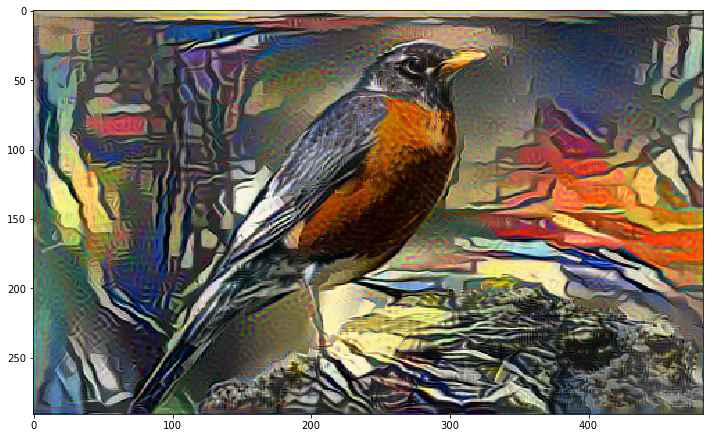

In [397]:
plt.figure(figsize=(12,12))
plt.imshow(deproc(y.copy(), shp)[0])